QED Data 3 to 2 processes.

Transformer code adapted from https://keras.io/examples/nlp/neural_machine_translation_with_transformer/

In [ ]:
pip install icecream more_itertools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# only needed for colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/SYMBA/2022-08-24-Transformer-NewData')
# os.chdir("..")

In [ ]:
os.listdir()

['Notebooks',
 'models',
 '2022-08-24-Transformer',
 '2022-08-24-Transformer_UpTo2to2',
 '2022-08-24-Transformer_3to2']

In [ ]:
import sys
import os
from icecream import ic 
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# from source.read_amplitudes import read_amplitudes, fix_operator_num_args, get_tree, fix_tree, fix_subscript, fix_subscripts, read_amplitudes_and_squares
  

In [ ]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization


In [ ]:
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Reading in Data

In [ ]:
os.listdir()

['Notebooks',
 'models',
 '2022-08-24-Transformer',
 '2022-08-24-Transformer_UpTo2to2',
 '2022-08-24-Transformer_3to2']

In [ ]:
amplitudes_file = "../data.nosync/QED_amplitudes_TreeLevel_3to2.txt"
sqamplitudes_file = "../data.nosync/QED_sqamplitudes_TreeLevel_3to2_simplified_hybrid_prefix_2.txt"

In [ ]:
X = []
with open(amplitudes_file, 'r') as f:
    for line in f.readlines() :
        line = line.split(",")
        line[-1] = line[-1].replace("\n", "")
        X.append(line)

y = []
with open(sqamplitudes_file, 'r') as f:
    for line in f.readlines() :
        line = line.split(",")
        line[-1] = line[-1].replace("\n", "")
        line = ["[START]"] + line + ["[END]"]
        y.append(line)

In [ ]:
np.array(y[0])

array(['[START]', 'mul(', 'mul', 's-', '16', 'pow', '9', 's-', '1', 'pow',
       'e', '6', 'pow', 'add(', 'mul(', 's-', '1', 'reg_prop', ')',
       'mul(', '2', 's_34', ')', ')', 's-', '2', 'pow', 'add(',
       'reg_prop', 'mul(', 's-', '2', 's_14', ')', 'mul(', 's-', '2',
       's_34', ')', 'mul(', '2', 'm2e', ')', 'mul(', '2', 's_13', ')',
       ')', 's-', '2', 'add(', 'mul(', 's-', '1', 'm4exs_25', ')', 'mul(',
       'm2dxs_13', 's_34', ')', 'mul(', 'm2e', 'add(', 'mul(', 's_12',
       's_45', ')', 'mul(', 's_15', 's_24', ')', 'mul(', 's_25', 's_34',
       ')', 'mul(', 's-', '1', 's_12', 's_35', ')', 'mul(', 's-', '1',
       's_15', 's_23', ')', ')', ')', 'mul(', '2', 'm2d', 'm4e', ')',
       'mul(', 'm2d', 'm2e', 'add(', 's_13', 'mul(', 's-', '1', 's_14',
       ')', 'mul(', 's-', '2', 's_34', ')', ')', ')', 'mul(', 's-', '1',
       's_12', 's_34', 's_35', ')', 'mul(', 's-', '1', 's_15', 's_23',
       's_34', ')', ')', ')', '[END]'], dtype='<U8')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

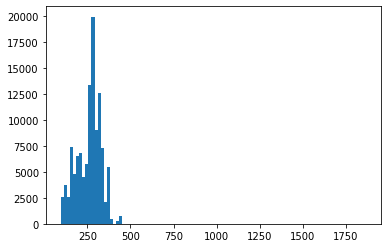

In [ ]:
plt.hist([len(x) for x in y_train], bins=100);

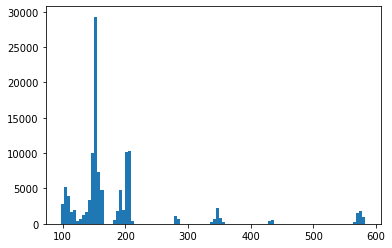

In [ ]:
plt.hist([len(x) for x in X_train], bins=100);

In [ ]:
vocab_size = 500
sequence_length = 350
batch_size = 64

Only use those X,y where both are at most `sequence_length` long.

In [ ]:
X_train_idx_okay = np.where([len(x) < sequence_length for x in X_train])[0]
y_train_idx_okay = np.where([len(y) < sequence_length for y in y_train])[0]
X_val_idx_okay = np.where([len(x) < sequence_length for x in X_val])[0]
y_val_idx_okay = np.where([len(x) < sequence_length for x in y_val])[0]
X_test_idx_okay = np.where([len(x) < sequence_length for x in X_test])[0]
y_test_idx_okay = np.where([len(x) < sequence_length for x in y_test])[0]
ic(len(X_train_idx_okay));
ic(len(y_train_idx_okay));
ic(len(X_val_idx_okay));
ic(len(y_val_idx_okay));
ic(len(X_test_idx_okay));
ic(len(y_test_idx_okay));

ic| len(X_train_idx_okay): 109829
ic| len(y_train_idx_okay): 107317
ic| len(X_val_idx_okay): 6081
ic| len(y_val_idx_okay): 5942
ic| len(X_test_idx_okay): 6130
ic| len(y_test_idx_okay): 5967


In [ ]:
train_idx_okay = np.intersect1d(X_train_idx_okay, y_train_idx_okay) 
val_idx_okay = np.intersect1d(X_val_idx_okay, y_val_idx_okay) 
test_idx_okay = np.intersect1d(X_test_idx_okay, y_test_idx_okay) 

In [ ]:
X_train_short = [X_train[i] for i in train_idx_okay]
y_train_short = [y_train[i] for i in train_idx_okay]

X_val_short = [X_val[i] for i in val_idx_okay]
y_val_short = [y_val[i] for i in val_idx_okay]

X_test_short = [X_test[i] for i in test_idx_okay]
y_test_short = [y_test[i] for i in test_idx_okay]

In [ ]:
X_train_text = [" ".join(x) for x in X_train_short]
y_train_text = [" ".join(yy) for yy in y_train_short]

X_val_text = [" ".join(x) for x in X_val_short]
y_val_text = [" ".join(yy) for yy in y_val_short]

X_test_text = [" ".join(x) for x in X_test_short]
y_test_text = [" ".join(yy) for yy in y_test_short]

In [ ]:
X_train_text[0]

'Prod( 8/27 i Pow e 3 Pow Sum( Pow m_u 2 s_11 Prod 2 s_13 reg_prop ) -1 Pow Sum( Pow m_u 2 s_11 Prod 2 s_12 Prod 2 s_13 Prod 2 s_23 reg_prop ) -1 Sum( Prod( p_1 alpha_18 gamma alpha_17 alpha_0 alpha_9 gamma alpha_17 alpha_2 alpha_13 gamma alpha_18 alpha_9 alpha_10 gamma alpha_16 alpha_10 alpha_1 A^(*) i_2 alpha_16 (p_5) u i_0 alpha_13 (p_1)_u u^(*) i_3 alpha_0 (p_2)_v u^(*) i_4 alpha_2 (p_3)_v u i_1 alpha_1 (p_4)_v ) Prod( 2 p_2 alpha_17 gamma alpha_17 alpha_3 alpha_14 gamma alpha_16 alpha_4 alpha_5 A^(*) i_2 alpha_16 (p_5) u i_0 alpha_14 (p_1)_u u^(*) i_3 alpha_4 (p_2)_v u^(*) i_4 alpha_3 (p_3)_v u i_1 alpha_5 (p_4)_v ) Prod( p_3 alpha_18 gamma alpha_17 alpha_6 alpha_11 gamma alpha_17 alpha_8 alpha_15 gamma alpha_18 alpha_11 alpha_12 gamma alpha_16 alpha_12 alpha_7 A^(*) i_2 alpha_16 (p_5) u i_0 alpha_15 (p_1)_u u^(*) i_3 alpha_6 (p_2)_v u^(*) i_4 alpha_8 (p_3)_v u i_1 alpha_7 (p_4)_v ) ) )'

In [ ]:
y_train_text[0]

'[START] mul( mul 512 pow 729 s- 1 pow e 6 pow add( m2u reg_prop s_11 mul( 2 s_13 ) ) s- 2 pow add( m2u reg_prop s_11 mul( 2 s_12 ) mul( 2 s_13 ) mul( 2 s_23 ) ) s- 2 add( mul( 8 m6u ) mul( m2u add( mul( 4 pow s_13 2 ) mul( s_14 s_23 ) mul( s- 1 s_11 s_24 ) mul( s- 8 s_12 s_23 ) mul( s- 4 s_11 s_23 ) mul( s- 4 s_13 s_24 ) mul( s- 2 s_13 s_14 ) mul( s- 2 s_13 s_34 ) mul( 2 s_11 s_13 ) mul( 2 s_12 s_24 ) mul( 2 s_23 s_34 ) mul( 3 s_12 s_34 ) mul( 4 s_12 s_14 ) ) ) mul( m4u add( mul( s- 3 s_24 ) mul( s- 2 s_14 ) mul( s- 2 s_34 ) mul( 4 s_11 ) mul( 4 s_23 ) mul( 14 s_13 ) ) ) mul( s- 2 s_14 pow s_23 2 ) mul( s- 2 s_34 pow s_12 2 ) mul( s_11 s_14 s_23 ) mul( s- 1 s_11 s_12 s_34 ) mul( 2 s_11 s_23 s_24 ) mul( 2 s_11 s_23 s_34 ) mul( 2 s_12 s_13 s_14 ) mul( 2 s_12 s_13 s_24 ) mul( 2 s_12 s_14 s_23 ) mul( 2 s_12 s_23 s_34 ) mul( 2 s_13 s_23 s_24 ) mul( 2 s_13 s_23 s_34 ) mul( 4 s_12 s_23 s_24 ) ) ) [END]'

# Vectorization

In [ ]:
def custom_standardization(input_string):
    return input_string

In [ ]:
X_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    standardize=None,
)

y_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length+1,
    standardize=None,
)

In [ ]:
X_vectorization.adapt(X_train_text)
y_vectorization.adapt(y_train_text)

In [ ]:
X_vectorization(X_train_text[0])

<tf.Tensor: shape=(350,), dtype=int64, numpy=
array([  6, 127,  51,   5,  52,  53,   5,  17,   5, 106,  16,  87,   4,
        16,  62,  32,   3,   7,   5,  17,   5, 106,  16,  87,   4,  16,
        84,   4,  16,  62,   4,  16,  86,  32,   3,   7,  17,   6,  59,
        15,   2,   8,  23,  25,   2,   8,  21,  34,   2,  15,  25,  18,
         2,  14,  18,  22,  42,  11,  14,  38,  75,  13,  34,  33,  74,
        10,  23,  45,  74,   9,  21,  55,  75,  12,  22,  43,   3,   6,
        16,  61,   8,   2,   8,  26,  40,   2,  14,  28,  31,  42,  11,
        14,  38,  75,  13,  40,  33,  74,  10,  28,  45,  74,   9,  26,
        55,  75,  12,  31,  43,   3,   6,  60,  15,   2,   8,  30,  20,
         2,   8,  27,  39,   2,  15,  20,  24,   2,  14,  24,  29,  42,
        11,  14,  38,  75,  13,  39,  33,  74,  10,  30,  45,  74,   9,
        27,  55,  75,  12,  29,  43,   3,   3,   3,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  

In [ ]:
def format_dataset(X, y):
    X_vec = X_vectorization(X)
    y_vec = y_vectorization(y)
    return (
        {
            "encoder_inputs": X_vec,
            "decoder_inputs": y_vec[:, :-1],
        },
        y_vec[:, 1:],
    )


def make_dataset(X_text, y_text):
    dataset = tf.data.Dataset.from_tensor_slices((X_text, y_text))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(X_train_text, y_train_text)
val_ds = make_dataset(X_val_text, y_val_text)
test_ds = make_dataset(X_test_text, y_test_text)


In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")


inputs["encoder_inputs"].shape: (64, 350)
inputs["decoder_inputs"].shape: (64, 350)
targets.shape: (64, 350)


In [ ]:
for inputs, targets in train_ds.take(1):
    print(inputs)
    print(targets)

{'encoder_inputs': <tf.Tensor: shape=(64, 350), dtype=int64, numpy=
array([[  6, 129,  51, ...,   0,   0,   0],
       [  6, 128,  51, ...,   0,   0,   0],
       [  6, 128,  51, ...,   0,   0,   0],
       ...,
       [  6, 128,  51, ...,   0,   0,   0],
       [  6, 127,  51, ...,   0,   0,   0],
       [  6, 129,  51, ...,   0,   0,   0]])>, 'decoder_inputs': <tf.Tensor: shape=(64, 350), dtype=int64, numpy=
array([[29,  3, 31, ...,  0,  0,  0],
       [29,  3, 31, ...,  0,  0,  0],
       [29,  3, 31, ...,  0,  0,  0],
       ...,
       [29,  3, 31, ...,  0,  0,  0],
       [29,  3, 31, ...,  0,  0,  0],
       [29,  3, 31, ...,  0,  0,  0]])>}
tf.Tensor(
[[ 3 31 63 ...  0  0  0]
 [ 3 31  5 ...  0  0  0]
 [ 3 31  5 ...  0  0  0]
 ...
 [ 3 31  5 ...  0  0  0]
 [ 3 31  5 ...  0  0  0]
 [ 3 31 61 ...  0  0  0]], shape=(64, 350), dtype=int64)


In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


In [ ]:
embed_dim = 256  # 512
latent_dim = 2048  # 16384
num_heads = 8

# with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
encoder_inputs = keras.Input(shape=(None,), dtype="int32", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int32", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)
transformer.summary()


Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   217600      ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

In [ ]:
def learning_rate_cyclic(epoch):
    initial_lr = 0.0005
    max_lr = 0.004
    max_epochs = 40
    if epoch <= (max_epochs / 2):
        lr = initial_lr + (max_lr-initial_lr) * epoch/(max_epochs/2)
        return lr
    if (epoch > (max_epochs / 2)) & (epoch < max_epochs):
        lr = max_lr - (max_lr-initial_lr) * (epoch-max_epochs/2)/(max_epochs/2)
        return lr
    else:
        lr = initial_lr*np.exp(-(epoch-max_epochs)/10)
        return lr

Text(0, 0.5, 'learning rate')

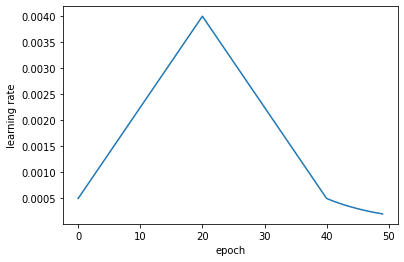

In [ ]:
xrange = range(0,50)
yrange = [learning_rate_cyclic(x) for x in xrange]
plt.plot(xrange, yrange)
plt.xlabel("epoch")
plt.ylabel("learning rate")

In [ ]:
epochs = 50  # This should be at least 30 for convergence
lr_schedule = tf.keras.callbacks.LearningRateScheduler(learning_rate_cyclic)
checkpoint = keras.callbacks.ModelCheckpoint(
    "models/2022-08-28-Transformer_3to2", save_best_only=True, monitor="val_loss", save_weights_only=True
)

callbacks = [lr_schedule]

transformer.summary()
transformer.compile(
    "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds,
                          callbacks = callbacks)


Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   217600      ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

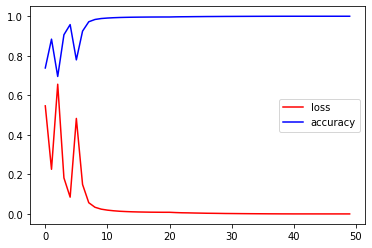

In [ ]:
plt.plot(history.history['loss'], c="r", label="loss")
plt.plot(history.history['accuracy'], c='b', label="accuracy")
plt.legend()
plt.show()

In [ ]:
# transformer.save("models/2022-08-24-Transformer")
transformer.save_weights("models/2022-08-28-Transformer_3to2")

In [ ]:
loaded_transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="loaded_transformer"
)
loaded_transformer.load_weights("models/2022-08-28-Transformer_3to2")

In [ ]:
y_vocab = y_vectorization.get_vocabulary()
y_index_lookup = dict(zip(range(len(y_vocab)), y_vocab))
max_decoded_sentence_length = 350


def decode_sequence(input_sentence):
    tokenized_input_sentence = X_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = y_vectorization([decoded_sentence])[:, :-1]
        predictions = loaded_transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = y_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[END]":
            break
    return decoded_sentence

In [ ]:
len(X_val_text)

5702

In [ ]:
%%time
decode_sequence(X_train_text[0])

CPU times: user 10.6 s, sys: 948 ms, total: 11.6 s
Wall time: 11 s


'[start] mul( mul 512 pow 729 s- 1 pow e 6 pow add( m2u reg_prop s_11 mul( 2 s_13 ) ) s- 2 pow add( m2u reg_prop s_11 mul( 2 s_12 ) mul( 2 s_13 ) mul( 2 s_23 ) ) s- 2 add( mul( 8 m6u ) mul( m2u add( mul( 4 pow s_13 2 ) mul( s_14 s_23 ) mul( s- 1 s_11 s_24 ) mul( s- 8 s_12 s_23 ) mul( s- 4 s_11 s_23 ) mul( s- 4 s_13 s_24 ) mul( s- 2 s_13 s_14 ) mul( s- 2 s_13 s_34 ) mul( 2 s_11 s_13 ) mul( 2 s_12 s_24 ) mul( 2 s_23 s_34 ) mul( 3 s_12 s_34 ) mul( 4 s_12 s_14 ) ) ) mul( m4u add( mul( s- 3 s_24 ) mul( s- 2 s_14 ) mul( s- 2 s_34 ) mul( 4 s_11 ) mul( 4 s_23 ) mul( 14 s_13 ) ) ) mul( s- 2 s_14 pow s_23 2 ) mul( s- 2 s_34 pow s_12 2 ) mul( s_11 s_14 s_23 ) mul( s- 1 s_11 s_12 s_34 ) mul( 2 s_11 s_23 s_24 ) mul( 2 s_11 s_23 s_34 ) mul( 2 s_12 s_13 s_14 ) mul( 2 s_12 s_13 s_24 ) mul( 2 s_12 s_14 s_23 ) mul( 2 s_12 s_23 s_34 ) mul( 2 s_13 s_23 s_24 ) mul( 2 s_13 s_23 s_34 ) mul( 4 s_12 s_23 s_24 ) ) ) [END]'

In [ ]:
y_train_text[0]

'[START] mul( mul 512 pow 729 s- 1 pow e 6 pow add( m2u reg_prop s_11 mul( 2 s_13 ) ) s- 2 pow add( m2u reg_prop s_11 mul( 2 s_12 ) mul( 2 s_13 ) mul( 2 s_23 ) ) s- 2 add( mul( 8 m6u ) mul( m2u add( mul( 4 pow s_13 2 ) mul( s_14 s_23 ) mul( s- 1 s_11 s_24 ) mul( s- 8 s_12 s_23 ) mul( s- 4 s_11 s_23 ) mul( s- 4 s_13 s_24 ) mul( s- 2 s_13 s_14 ) mul( s- 2 s_13 s_34 ) mul( 2 s_11 s_13 ) mul( 2 s_12 s_24 ) mul( 2 s_23 s_34 ) mul( 3 s_12 s_34 ) mul( 4 s_12 s_14 ) ) ) mul( m4u add( mul( s- 3 s_24 ) mul( s- 2 s_14 ) mul( s- 2 s_34 ) mul( 4 s_11 ) mul( 4 s_23 ) mul( 14 s_13 ) ) ) mul( s- 2 s_14 pow s_23 2 ) mul( s- 2 s_34 pow s_12 2 ) mul( s_11 s_14 s_23 ) mul( s- 1 s_11 s_12 s_34 ) mul( 2 s_11 s_23 s_24 ) mul( 2 s_11 s_23 s_34 ) mul( 2 s_12 s_13 s_14 ) mul( 2 s_12 s_13 s_24 ) mul( 2 s_12 s_14 s_23 ) mul( 2 s_12 s_23 s_34 ) mul( 2 s_13 s_23 s_24 ) mul( 2 s_13 s_23 s_34 ) mul( 4 s_12 s_23 s_24 ) ) ) [END]'

In [ ]:
def token_accuracy(y_true, y_pred, verbose=0, pred_has_start_end_tokens=True):
    """
    compare two arrays and check how many entries are the same at the same position
    """
    true = y_true.split(" ")
    pred = y_pred.split(" ")
    if pred_has_start_end_tokens:
        pred = pred[1:-1]
    max_ind = np.min([len(true), len(pred)])
    correct_ctr = 0
    # ignore [start] and [end]
    max_correct = len(pred)
    for i in range(max_ind):
        if verbose: ic([true[i], pred[i]])
        if true[i] == pred[i]:
            correct_ctr += 1
    return correct_ctr / max_correct

In [ ]:
y_train_pred = [decode_sequence(x) for x in X_train_text[0:200]]
y_val_pred = [decode_sequence(x) for x in X_val_text[0:200]]

In [ ]:
train_true_file = "predictions/train_true.txt"
train_pred_file = "predictions/train_pred.txt"
test_true_file = "predictions/test_true.txt"
test_pred_file = "predictions/test_pred.txt"

with open(train_true_file, "w") as f:
    for line in y_train_text:
        f.write(line)

with open(train_pred_file, "w") as f:
    for line in y_train_pred:
        f.write(line)

with open(test_pred_file, "w") as f:
    for line in y_val_pred:
        f.write(line)

with open(test_true_file, "w") as f:
    for line in y_val_text:
        f.write(line)

In [ ]:
np.array(y_train_pred[0].split(" "))

array(['[start]', 'mul(', 'mul', '512', 'pow', '729', 's-', '1', 'pow',
       'e', '6', 'pow', 'add(', 'm2u', 'reg_prop', 's_11', 'mul(', '2',
       's_13', ')', ')', 's-', '2', 'pow', 'add(', 'm2u', 'reg_prop',
       's_11', 'mul(', '2', 's_12', ')', 'mul(', '2', 's_13', ')', 'mul(',
       '2', 's_23', ')', ')', 's-', '2', 'add(', 'mul(', '8', 'm6u', ')',
       'mul(', 'm2u', 'add(', 'mul(', '4', 'pow', 's_13', '2', ')',
       'mul(', 's_14', 's_23', ')', 'mul(', 's-', '1', 's_11', 's_24',
       ')', 'mul(', 's-', '8', 's_12', 's_23', ')', 'mul(', 's-', '4',
       's_11', 's_23', ')', 'mul(', 's-', '4', 's_13', 's_24', ')',
       'mul(', 's-', '2', 's_13', 's_14', ')', 'mul(', 's-', '2', 's_13',
       's_34', ')', 'mul(', '2', 's_11', 's_13', ')', 'mul(', '2', 's_12',
       's_24', ')', 'mul(', '2', 's_23', 's_34', ')', 'mul(', '3', 's_12',
       's_34', ')', 'mul(', '4', 's_12', 's_14', ')', ')', ')', 'mul(',
       'm4u', 'add(', 'mul(', 's-', '3', 's_24', ')', 'mul(', '

In [ ]:
np.array(y_train[0])

array(['[START]', 'mul(', 'mul', '512', 'pow', '729', 's-', '1', 'pow',
       'e', '6', 'pow', 'add(', 'm2u', 'reg_prop', 's_11', 'mul(', '2',
       's_13', ')', ')', 's-', '2', 'pow', 'add(', 'm2u', 'reg_prop',
       's_11', 'mul(', '2', 's_12', ')', 'mul(', '2', 's_13', ')', 'mul(',
       '2', 's_23', ')', ')', 's-', '2', 'add(', 'mul(', '8', 'm6u', ')',
       'mul(', 'm2u', 'add(', 'mul(', '4', 'pow', 's_13', '2', ')',
       'mul(', 's_14', 's_23', ')', 'mul(', 's-', '1', 's_11', 's_24',
       ')', 'mul(', 's-', '8', 's_12', 's_23', ')', 'mul(', 's-', '4',
       's_11', 's_23', ')', 'mul(', 's-', '4', 's_13', 's_24', ')',
       'mul(', 's-', '2', 's_13', 's_14', ')', 'mul(', 's-', '2', 's_13',
       's_34', ')', 'mul(', '2', 's_11', 's_13', ')', 'mul(', '2', 's_12',
       's_24', ')', 'mul(', '2', 's_23', 's_34', ')', 'mul(', '3', 's_12',
       's_34', ')', 'mul(', '4', 's_12', 's_14', ')', ')', ')', 'mul(',
       'm4u', 'add(', 'mul(', 's-', '3', 's_24', ')', 'mul(', '

In [ ]:
train_accs = [token_accuracy(y_train_text[i], y_train_pred[i], pred_has_start_end_tokens=False) for i in range(len(y_train_pred))]
val_accs = [token_accuracy(y_val_text[i], y_val_pred[i], pred_has_start_end_tokens=False) for i in range(len(y_val_pred))]

In [ ]:
print("train:", np.mean(train_accs))
print("val:", np.mean(val_accs)) 

train: 0.981242872773384
val: 0.9654626999366843


In [ ]:
for inputs, targets in train_ds.take(1):
    print(inputs['encoder_inputs'][0])
    print(targets[0])

tf.Tensor(
[  6 138  51   5  52  53   5  17   5 107  16   4  16  86   4  35  88  85
   4  35  63  32   3   7   5  17   5 107  16   4   7  88   4  54  32   3
   7   2  25  23  29   2  25  21  26  17   4 107   2  27  26  22   6   7
  61  18   2  18  26  28   2  27  28  22   3   6   7  60  18   2  18  26
  31   2  27  31  22   3   6  58  18   2  18  26  30   2  27  30  22   3
   3  42  11  27  38  67  13  22  33  66  10  23  45  66   9  21  55  67
  12  29  43   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0